I'm a big fan of 2D protein--ligand interaction diagrams; when well done these plots can provide an information-dense view of the structure that is still easy to understand.

A really nice example of this is the work on [PoseView](https://doi.org/10.1021/ml100164p) from Matthias Rarey's group in Hamburg. Here's an example from that publication:
![image](https://pubs.acs.org/cms/10.1021/ml100164p/asset/images/medium/ml-2010-00164p_0005.gif)

Though I would love to have an RDKit implementation of PoseView, actually implementing something like that is deeply nontrivial, so I've never really done anything in that direction. This week I had a random idea for a way to provide basic protein--ligand interaction diagrams using existing RDKit functionality. This post is an exploration of that.

Here's an example of what you get with this:
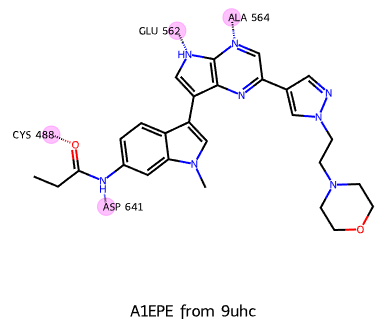

To be clear: I am fully aware that this is not nearly as good as what PoseView and similar tools can do, but I think it's still quite useful. I have a few ideas for straightforward changes to the backend code to improve the plots that I'm also going to take a look at.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem import Draw
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 400,400
import rdkit
print(rdkit.__version__)

2025.03.6


# Initial exploration

Start with the ligand for a recent PDB structure, 8yqe:

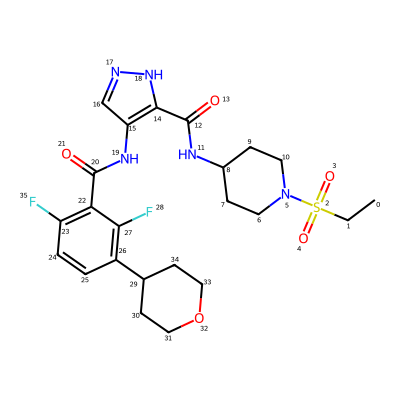

In [2]:
# from https://www.ebi.ac.uk/pdbe/entry/pdb/8yqe?activeTab=ligands
lig = Chem.MolFromSmiles('CCS(=O)(=O)N1CCC(CC1)NC(=O)c2c(cn[nH]2)NC(=O)c3c(ccc(c3F)C4CCOCC4)F')
IPythonConsole.drawOptions.addAtomIndices = True
lig

The strategy to draw the interaction diagrams is to add a new dummy atom to the ligand molecule for each residue it's interacting with and then connect that to the interacting ligand atom with a zero-order bond. The standard RDKit 2D coordinate generation code will then do something sensible with this.

I include `hbond` interactions that are around 3.0$\AA$ or less from the list of interactions on the [ligand page](https://www.ebi.ac.uk/pdbe/entry/pdb/8yqe?activeTab=ligands)

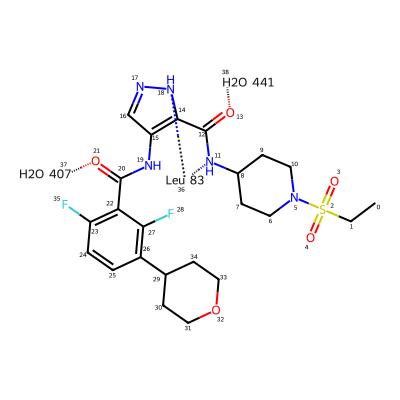

In [3]:
lig_with_interactions = Chem.RWMol(lig)
leu83 = Chem.Atom(0)
leu83.SetProp('atomLabel','Leu 83')
aid = lig_with_interactions.AddAtom(leu83)
lig_with_interactions.AddBond(18,aid,Chem.BondType.ZERO)
lig_with_interactions.AddBond(11,aid,Chem.BondType.ZERO)

hoh407 = Chem.Atom(0)
hoh407.SetProp('atomLabel','H2O 407')
aid = lig_with_interactions.AddAtom(hoh407)
lig_with_interactions.AddBond(21,aid,Chem.BondType.ZERO)

hoh441 = Chem.Atom(0)
hoh441.SetProp('atomLabel','H2O 441')
aid = lig_with_interactions.AddAtom(hoh441)
lig_with_interactions.AddBond(13,aid,Chem.BondType.ZERO)

# this doesn't work because the ring centroid doesn't get put in the middle of the ring
# ring_center = Chem.Atom(0)
# aid = lig_with_interactions.AddAtom(ring_center)
# for rid in (22,23,24,25,26,27):
#     lig_with_interactions.AddBond(rid,aid,Chem.BondType.ZERO)

lig_with_interactions

# Making it easier to use

That doesn't look terrible. Write a function to automate the process and include highlights around the residue pseudo-atoms:

In [4]:
def draw_ligand_with_interactions(lig,lig_name,interactions,size=(400,400)):   
    lig_with_interactions = Chem.RWMol(lig)
    
    # add pseudo-atoms (and bonds to them) for the interacting residues:
    pts = []
    clrs = {}
    for (aname,oaids) in interactions:
        res = Chem.Atom(0)
        res.SetProp('atomLabel',aname)
        aid = lig_with_interactions.AddAtom(res)
        pts.append(aid)
        clrs[aid] = (1,.2,1,.3)
        for oaid in oaids:
            lig_with_interactions.AddBond(aid,oaid,Chem.BondType.ZERO)
   
    d2d = Draw.MolDraw2DSVG(size[0],size[1])
    
    # set the draw options so that we end up with circles under the pseudo-atoms:
    d2d.drawOptions().circleAtoms = True
    d2d.drawOptions().fillHighlights = True
    d2d.drawOptions().continuousHighlight = False
    d2d.drawOptions().highlightRadius = 0.5
    
    # now draw and return the result
    d2d.DrawMolecule(lig_with_interactions,legend=lig_name,
                     highlightAtoms=pts,highlightAtomColors=clrs)
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())




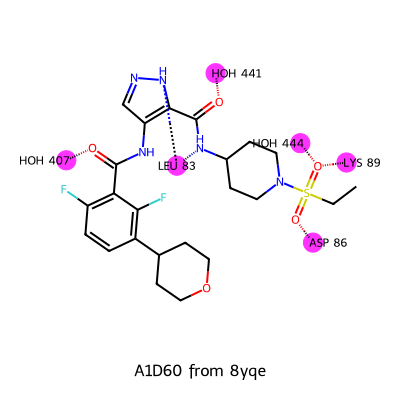

In [5]:
# from https://www.ebi.ac.uk/pdbe/entry/pdb/8yqe?activeTab=ligands
lig = Chem.MolFromSmiles('CCS(=O)(=O)N1CCC(CC1)NC(=O)c2c(cn[nH]2)NC(=O)c3c(ccc(c3F)C4CCOCC4)F')
interactions = (
    ('LYS 89',(3,)),
    ('ASP 86',(4,)),
    ('HOH 444',(3,)),
    ('HOH 441',(13,)),
        ('HOH 407',(21,)),
        ('LEU 83',(18,11)),
)
draw_ligand_with_interactions(lig,'A1D60 from 8yqe',interactions)

Do a couple more examples using other recent PDB structures:

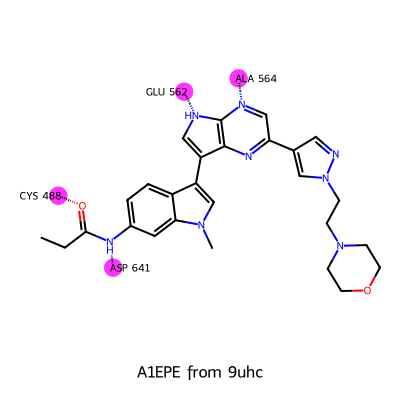

In [6]:
# from: https://www.ebi.ac.uk/pdbe/entry/pdb/9uhc?activeTab=ligands
lig = Chem.MolFromSmiles('CCC(=O)Nc1ccc2c(c1)n(cc2c3c[nH]c4c3nc(cn4)c5cnn(c5)CCN6CCOCC6)C')
interactions = (
    ('ALA 564',(22,)),
    ('GLU 562',(16,)),
    ('ASP 641',(4,)),
    ('CYS 488',(3,)),
)
draw_ligand_with_interactions(lig,'A1EPE from 9uhc',interactions)

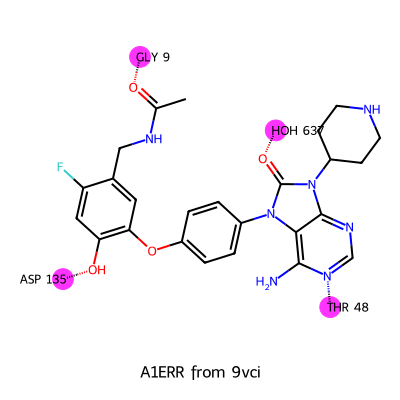

In [7]:
# from https://www.ebi.ac.uk/pdbe/entry/pdb/9vci?activeTab=ligands
lig = Chem.MolFromSmiles('CC(=O)NCc1cc(c(cc1F)O)Oc2ccc(cc2)N3c4c(ncnc4N(C3=O)C5CCNCC5)N')
interactions = (
        ('GLY 9',(2,)),
        ('ASP 135',(12,)),
        ('THR 48',(23,)),
        ('HOH 637',(29,)),
)
draw_ligand_with_interactions(lig,'A1ERR from 9vci',interactions)

There's clearly room for improvement here (and I have a couple of ideas already), but I think this is already useful as-is.